In [1]:
from fastai.vision.all import *
import fastai
import timm
import torch
torch.cuda.set_device(2)

df = pd.read_csv('../trainValidAll.csv.csv')

In [2]:
def is_valid(path):
    name = path[1]
    return (df[df['nombre_foto']==name])['set'].values[0]=='validation'

In [3]:
def get_class(path):
    name = path[1]
    return int((df[df['nombre_foto']==name])['binary'])

In [4]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=20),
    SaveModelCallback(fname='resnetrs224All',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(384)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

dsets = db.datasets(df.values)

TypeError: type.__new__() argument 1 must be str, not numpy.ndarray

In [6]:
labels = df.binary.values
count = Counter(labels)
wgts = [1/count[dsets.vocab[label]] for img, label in dsets.train]

In [7]:
dls = db.dataloaders(df.values,bs=128,num_workers=0, dl_type=WeightedDL, wgts=wgts)

In [8]:
learn = Learner(dls,timm.create_model('resnetrs50',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= LabelSmoothingCrossEntropy()).to_fp16()

SuggestedLRs(valley=0.00019054606673307717)

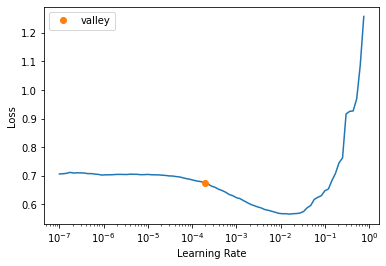

In [9]:
#learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.406683,0.348920,0.972408,0.393597,0.535897,0.453855,0.907108,08:47


Better model found at epoch 0 with f1_score value: 0.4538545059717698.


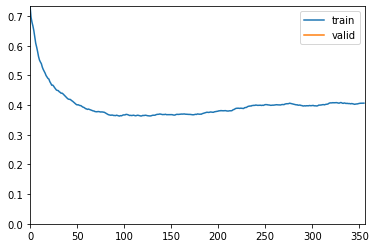

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.308969,0.282213,0.950411,0.278448,0.828205,0.416774,0.956504,08:47
1,0.283438,0.303075,0.941306,0.243590,0.828205,0.376457,0.948310,08:51
2,0.277905,0.295211,0.947778,0.266611,0.823077,0.402760,0.944040,08:51
3,0.266745,0.268300,0.962479,0.334459,0.761538,0.464789,0.945059,08:49
4,0.261733,0.303841,0.938947,0.236708,0.833333,0.368690,0.931828,08:49
5,0.260949,0.264514,0.962863,0.338219,0.769231,0.469851,0.950613,08:48
6,0.255771,0.253010,0.969720,0.390836,0.743590,0.512367,0.940734,08:51
7,0.252030,0.258458,0.969665,0.384068,0.692308,0.494053,0.922963,08:47
8,0.256132,0.271932,0.959078,0.309829,0.743590,0.437406,0.936104,08:49
9,0.257124,0.260258,0.964564,0.348341,0.753846,0.476499,0.946345,08:51


Better model found at epoch 0 with f1_score value: 0.41677419354838713.


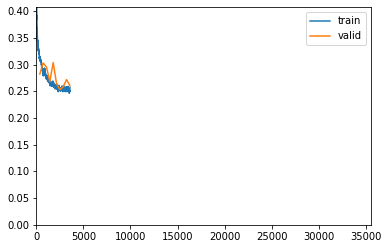

Better model found at epoch 3 with f1_score value: 0.46478873239436624.
Better model found at epoch 5 with f1_score value: 0.46985121378230227.
Better model found at epoch 6 with f1_score value: 0.5123674911660777.


In [ ]:
learn.fine_tune(100,base_lr=6e-3)